# 1. Imports

In [1]:
import numpy as np
from math import pi

In [2]:
from tensorflow.keras.models import load_model

In [3]:
from tensorflow.keras.losses import MSE
from tensorflow.keras.losses import categorical_crossentropy as CCE
import tensorflow as tf

In [4]:
from art.attacks.evasion import *
from art.estimators.classification import TensorFlowV2Classifier

from matplotlib import pyplot as plt

import numpy as np

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
import tensorflow as tf

import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
# Load properties from another python file
from properties import *

In [6]:
from random import random, randint

# 2. Load models

In [7]:
path_model = "ACAS_XU_tf_keras/ACASXU_1_1.h5"

In [8]:
model_11 = load_model(path_model)

In [ ]:
model_35 = load_model("ACAS_XU_tf_keras/ACASXU_3_5.h5")

In [9]:
model_11.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 50)                300       
_________________________________________________________________
activation_98 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 50)                2550      
_________________________________________________________________
activation_99 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 50)                2550      
_________________________________________________________________
activation_100 (Activation)  (None, 50)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 50)              

In [10]:
model_11.compile()

In [ ]:
model_35.compile()

In [ ]:
pt = np.array([1.0, 1.0, 1.0, 1.0, 1.0]).reshape(1,5)
model_11.predict(pt)

In [ ]:
pt = np.array([1.0, 1.0, 1.0, 1.0, 1.0]).reshape(1,5)
model_35.predict(pt)

In [29]:
ACAS_model = model_11

# 3. Carlini & Wagner = CW

In [ ]:
"""
def generate_adv_sample(model, x0, label, loss_function="MSE", eps=1e-5):
    # transforming into a tensorflow object
    x0_ = tf.cast(x0, tf.float32)
    
    # record our gradients
    with tf.GradientTape() as tape:
        # explicitly indicate that our input should be tacked for gradient updates
        tape.watch(x0_)

        # use our model to make predictions on the input and then compute the loss
        pred = model(x0_)
        if loss_function == "CCE":
            np_label = np.array([i==label for i in range(0,5)]).reshape((1,5))
            loss = CCE(np_label, pred)
        elif loss_function == "MSE":
            loss = MSE(label, pred)
        else:
            raise Exception("Unknown loss function '{0}'".format(loss_function))
        
        # calculate the gradients of loss with respect to the input, then compute the sign of the gradient
        gradient = tape.gradient(loss, x0_)
        signedGrad = tf.sign(gradient)

        # construct the image adversary
        adv_sample = (x0_ + (signedGrad * eps)).numpy()

        # return the adversarial sample to the calling function
        return(adv_sample)
"""

In [13]:
x_test = 0.8*np.array([[1.0, 1.0, 1.0, 1.0, 1.0],[0.6, 0.5, 1.0, 0.3, 1.0]])
print(x_test.shape)
print(x_test)

(2, 5)
[[0.8  0.8  0.8  0.8  0.8 ]
 [0.48 0.4  0.8  0.24 0.8 ]]


In [30]:
ACAS_classifier = TensorFlowV2Classifier(
    model=ACAS_model,
    loss_object=MSE,
    train_step=None,
    nb_classes=5,
    input_shape=(1, 5, 1),
    clip_values=(-1.0, 1.0),
)

In [14]:
attack_CW = CarliniLInfMethod(classifier=ACAS_classifier,
                              initial_const=1.0, 
                              max_iter=100, 
                              # targeted=True, 
                              verbose=True)

x_adv_cw = attack_CW.generate(x_test) #, y=np.array([[0,1,0,0,0]]))

print(x_adv_cw.shape)
print(x_adv_cw)


(2, 5)
[[0.8  0.8  0.8  0.8  0.8 ]
 [0.48 0.4  0.8  0.24 0.8 ]]


In [39]:
intensity_fgsm = 0.8

attack_FGSM = FastGradientMethod(estimator=ACAS_classifier,
                                 eps=intensity_fgsm)

x_adv_fgsm = attack_FGSM.generate(x_test)

print(x_adv_fgsm)

[[ 0.    0.    1.    0.    1.  ]
 [-0.32 -0.4   1.    1.    0.  ]]


# 4. Generate points

In [103]:
def random_pts(n, prop_dom, main_dom):
    """ prop_dom is a list of domains given by intervals in a numpy 2x5 table. """
    ndom = len(prop_dom)
    ndim = main_dom.shape[1]
    
    x = np.zeros((n,ndim))
    for i in range(n): # generate the i-th point
        choosen_dom = prop_dom[randint(0,ndom-1)] # choose the input property domain for a given prop
        for k in range(ndim): # create a random coord for each dim
            boundaries = main_dom[:,k]
            if choosen_dom[0,k] != None:
                boundaries[0] = choosen_dom[0,k]
            if choosen_dom[1,k] != None:
                boundaries[1] = choosen_dom[1,k]
            x[i,k] = boundaries[0] + random()*(boundaries[1]-boundaries[0])

    return(x)

In [16]:
def random_main_pts(n, main_dom):
    """ Generate random points in the main domain given by intervals stored in a numpy 2x5 table. """
    ndim = main_dom.shape[1]
    
    x = np.zeros((n,ndim))
    for k in range(ndim): # create a random coord for each dim
        col = main_dom[0,k]*np.ones((n,1)) + np.random.rand(n,1)*(main_dom[1,k] - main_dom[0,k])
        for i in range(n):
            x[i,k] = col[i]

    return(x)

In [79]:
x_test = random_main_pts(1000, X_dom)

In [104]:
def normalize(x, x_mean, x_range):
    (n,k) = x.shape
    nx = np.zeros((n,k))
    for i in range(n):
        for j in range(k):
            nx[i,j] = (x[i,j]-x_mean[j])/x_range[j]
    return(nx)

In [105]:
def check_pts(model, input_pts, IP, OP):
    n = input_pts.shape[0]
    IO_check = np.zeros((n,2)) # 1st column : input checked - 2nd column : output checked
    
    norm_input = normalize(input_pts, X_mean, X_range) # normalize pts
    
    pred_pts = model.predict(norm_input) # make predictions with the model (neural net)
    
    for k in range(n):
        IO_check[k,0] = IP(input_pts[k,:]) # check input (just in case)
        IO_check[k,1] = OP(pred_pts[k,:]) # check output

    return(IO_check, pred_pts)

In [112]:
rand_inputs = random_pts(1000000, IP2_dom, X_dom)

In [113]:
Pcheck, pred_pts = check_pts(model_11, rand_inputs, IP1, OP1)

In [117]:
def find_adverse(input_pts, prop_check):
    n = prop_check.shape[0]
    index = []
    for k in range(n):
        if prop_check[k,0] and not(prop_check[k,1]):
            index.append(k)
    return(input_pts[index,:])

In [118]:
adv = find_adverse(rand_inputs, Pcheck)
print(adv.shape)

(0, 5)


In [116]:
Pcheck.shape

(1000000, 2)

# Try FGSM & CW

In [47]:
original_pts = np.random.rand(10, 5) # random_main_pts(10, X_dom)

In [48]:
print(original_pts)

[[0.8377245  0.74456    0.25902265 0.09397303 0.05569007]
 [0.47215357 0.71655417 0.21923121 0.898122   0.52910626]
 [0.5332981  0.22828044 0.29442809 0.78952536 0.6968603 ]
 [0.56954083 0.54455364 0.23186989 0.82858992 0.46137778]
 [0.490866   0.02590769 0.72713321 0.02189469 0.77439508]
 [0.82136041 0.26128093 0.12451134 0.99664711 0.23838506]
 [0.62239794 0.84862118 0.52782687 0.41611897 0.68149823]
 [0.90684225 0.38932749 0.17970234 0.61160592 0.87404112]
 [0.28027271 0.70340199 0.01710091 0.56575161 0.19973995]
 [0.12103047 0.00881489 0.25273928 0.46360088 0.63755401]]


In [49]:
adv_pts_cw = attack_CW.generate(original_pts)

In [50]:
adv_pts_fgsm = attack_FGSM.generate(original_pts)

In [51]:
print("CW")
print(adv_pts_cw)

print("FGSM")
print(adv_pts_fgsm)

CW
[[0.8377245  0.74456    0.25902265 0.09397303 0.05569007]
 [0.47215357 0.71655416 0.2192312  0.898122   0.52910626]
 [0.5332981  0.22828044 0.29442808 0.78952533 0.6968603 ]
 [0.56954086 0.54455364 0.23186989 0.8285899  0.46137777]
 [0.48535177 0.01856896 0.7332181  0.01858784 0.77924097]
 [0.8213604  0.26128092 0.12451134 0.9966471  0.23838505]
 [0.62239796 0.8486212  0.52782685 0.41611898 0.6814982 ]
 [0.90684223 0.3893275  0.17970234 0.61160594 0.87404114]
 [0.28027272 0.703402   0.01710091 0.5657516  0.19973995]
 [0.12103047 0.00881489 0.25273928 0.46360087 0.637554  ]]
FGSM
[[ 0.0377245   1.         -0.54097736 -0.706027    0.85569006]
 [-0.32784644  1.          1.          0.09812201  1.        ]
 [ 1.          1.         -0.5055719   1.         -0.1031397 ]
 [-0.23045915 -0.25544637  1.          1.         -0.3386222 ]
 [-0.309134   -0.7740923   1.         -0.7781053   1.        ]
 [ 0.02136041 -0.53871906 -0.67548865  0.19664711  1.        ]
 [-0.17760205  0.04862119 -0.2721

In [52]:
original_pred = ACAS_model.predict(original_pts)

adv_pred_cw = ACAS_model.predict(adv_pts_cw)
adv_pred_fgsm = ACAS_model.predict(adv_pts_fgsm)

In [54]:
print("Original pred :")
print(original_pred)

print("CW pred :")
print(adv_pred_cw)
print("FGSM pred :")
print(adv_pred_fgsm)

Original pred :
[[0.19949643 0.20014174 0.20012534 0.20012468 0.2001118 ]
 [0.19952053 0.20013495 0.20011802 0.2001167  0.20010985]
 [0.1995482  0.20012693 0.20010968 0.20010777 0.20010735]
 [0.19953354 0.20013192 0.20011353 0.20011126 0.2001097 ]
 [0.1989527  0.19874685 0.20220192 0.19503412 0.20506445]
 [0.19956627 0.20012143 0.20010449 0.20010245 0.20010532]
 [0.19945754 0.20015381 0.20013644 0.20013584 0.20011644]
 [0.19953272 0.20013191 0.200114   0.20011197 0.20010942]
 [0.19960083 0.20011099 0.20009446 0.20009215 0.20010157]
 [0.19955824 0.20012242 0.20010786 0.20010726 0.2001042 ]]
CW pred :
[[0.19949643 0.20014174 0.20012534 0.20012468 0.2001118 ]
 [0.19952053 0.20013495 0.20011802 0.2001167  0.20010985]
 [0.1995482  0.20012693 0.20010968 0.20010777 0.20010735]
 [0.19953354 0.20013192 0.20011353 0.20011126 0.2001097 ]
 [0.19954535 0.19945152 0.20077102 0.19946922 0.20076291]
 [0.19956627 0.20012143 0.20010449 0.20010245 0.20010532]
 [0.19945754 0.20015381 0.20013644 0.20013584

In [55]:
original_advice = np.argmin(original_pred, axis=1)

cw_advice = np.argmin(adv_pred_cw, axis=1)
fgsm_advice = np.argmin(adv_pred_fgsm, axis=1)

In [56]:
print(original_advice)

print(cw_advice)
print(fgsm_advice)

[0 0 0 0 3 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0]
[0 4 0 0 2 0 0 0 3 4]


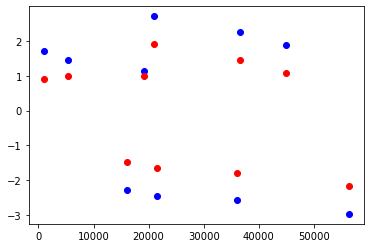

In [46]:
plt.scatter(original_pts[:,0], original_pts[:,1], color='blue')
plt.scatter(adv_pts_fgsm[:,0], adv_pts_fgsm[:,1], color='red')
plt.show()